In [28]:
import os
import pandas as pd
import numpy as np
import requests
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import pyeuropeana.apis as apis
import pyeuropeana.utils as utils

os.environ['EUROPEANA_API_KEY'] = 'api2demo'


In [56]:
# load watermark record and labeled_6999
record = pd.read_csv('/storage/data/watermark_record - Sheet1 (1).csv')
labeled = pd.read_csv('/storage/data/labeled_6999_report - labeled_6999_report.csv')
print(record.shape)
print(labeled.shape)

# get datasets with some in record
record = record.loc[record['watermarks'] == 'Some']
print(record.shape)

# get some and not reviewed datasets from labeled_6999
labeled = labeled.loc[labeled['watermarks'].apply(lambda x: x in ['Some',np.nan])]
labeled = labeled.head(200)
print(labeled.shape)

dataset_list = np.concatenate([record['dataset_name'].values,labeled['dataset_name'].values])
dataset_list = dataset_list.astype(str)

print(dataset_list.shape)
dataset_list = np.unique(dataset_list)
print(dataset_list.shape)

n_objects = 1000

df = pd.DataFrame()
for dataset in tqdm(dataset_list[:]):
    dataset_id = dataset.split('_')[0]
    response = apis.search(
        query = f'edm_datasetName:{dataset_id}_*',
        rows = n_objects,
        qf = 'TYPE:IMAGE',
        sort = 'random,europeana_id',
        )
    response = utils.search2df(response)

    df = pd.concat([df,response])


df.to_csv('/storage/data/sample_inference.csv',index = False)
print(df.shape)

(134, 8)
(451, 10)
(26, 8)
(200, 10)
(226,)
(191,)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [16:05<00:00,  5.06s/it]


(182600, 16)


In [2]:



#https://api.europeana.eu/record/v2/search.json?wskey=api2demo&query=*&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000

result = apis.search(
    query = '*',
    rows=0,
    profile = 'facets',
    facet = 'edm_datasetName&f.edm_datasetName.facet.limit=10000',
    )

df = pd.DataFrame(result['facets'][0]['fields'])

print(df)

dataset_df = df.loc[df['count']>=20]
#dataset_df = df.iloc[1000:1100]

print(dataset_df.shape)
print(dataset_df['count'].sum())

                                               label    count
0                          2058621_Ag_EU_LoCloud_NRA  2910176
1                    9200365_Ag_EU_TEL_a0142_Gallica  1191745
2     9200359_Ag_EU_TEL_a0601_Newspapers_Netherlands   747773
3                                   9200479_NLPoland   644682
4             9200384_Ag_EU_TEL_a0613_Newspapers_ONB   629498
...                                              ...      ...
2149                       856_ekultura_IlijaGultesa        1
2150                              88_ASINOU_1_Cyprus        1
2151                            895_APE_Landsarkivet        1
2152                            896_APE__Riksarkivet        1
2153           9200334_Ag_EU_TEL_a1223_EC1914_Slovak        1

[2154 rows x 2 columns]
(1941, 2)
62147757


In [39]:

# target datasets Ele 06 - 03

# https://api.europeana.eu/record/v2/search.json?wskey=api2demo&qf=TYPE:"IMAGE"&qf=COUNTRY:"Poland"&qf=COUNTRY:"Cyprus"&qf=COUNTRY:"Slovakia"&qf=COUNTRY:"Croatia"&qf=COUNTRY:"Bulgaria"&qf=COUNTRY:"Malta"&qf=COUNTRY:"Spain"&qf=COUNTRY:"Estonia"&query=contentTier:(3 OR 4)&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000


response = requests.get('https://api.europeana.eu/record/v2/search.json?wskey=api2demo&qf=TYPE:"IMAGE"&qf=COUNTRY:"Poland"&qf=COUNTRY:"Cyprus"&qf=COUNTRY:"Slovakia"&qf=COUNTRY:"Croatia"&qf=COUNTRY:"Bulgaria"&qf=COUNTRY:"Malta"&qf=COUNTRY:"Spain"&qf=COUNTRY:"Estonia"&query=contentTier:(3 OR 4)&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000')
response = response.json()
dataset_df = pd.DataFrame(response['facets'][0]['fields'])
dataset_df = dataset_df.loc[df['count']>=20]
dataset_df


,label,count
0,2024914_EuropeanaPhotography_Girona_1019,132899
1,2022719_Hispana_Galiciana_Arxivo,67261
2,2022717_Ag_ES_Hispana_Biblioteca_Nacional,30191
3,11617_Ag_EU_OpenUp!_UTNHM,26794
4,11624_Ag_OpenUp_GIT,24778
...,...,...
110,2058631_Ag_EU_LoCloud_PSRL-e,26
111,407_Cy_CUT_476,25
112,9200130_Ag_EU_TEL_a1013_Madrid,23
113,0940447_Ag_PL_bbc.mbp.org.pl,22


In [33]:
dataset_df['count'].mean()

3207.4055944055945

In [40]:
dataframe = pd.DataFrame()
for dataset_name in tqdm(dataset_df['label'].values[:]):
  result = apis.search(
      query = f'edm_datasetName:"{dataset_name}"',
      qf = 'TYPE:IMAGE', 
      rows = 1000
      )

  aggregator_list = [item['provider'][0] for item in result['items']]

  #print(aggregator_list)

  result = utils.search2df(result)

  #print(result.shape[0])
    
  if result is not None:
      result['dataset_name'] = dataset_name
      result['aggregator'] = aggregator_list
      
      dataframe = pd.concat([dataframe,result])

dataframe.to_csv('/storage/data/sample.csv',index = False)
dataframe.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [07:12<00:00,  3.76s/it]


(79548, 17)

(30270, 16)

Number of inferences: 5131
Number of datasets: 190


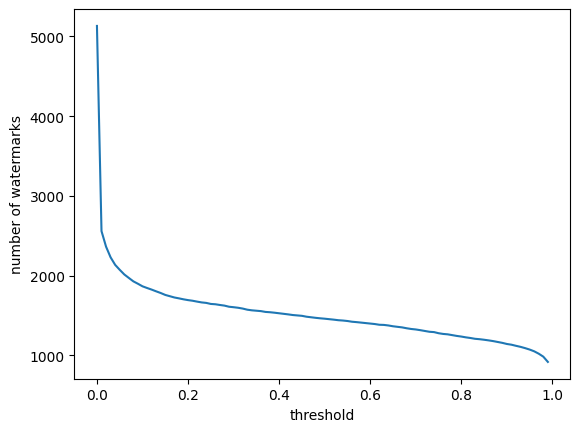

In [51]:
# Process inference

def fpath2id(x):
    return Path(x).with_suffix('').name.replace('[ph]','/')

meta_df = pd.read_csv('/storage/data/sample_inference.csv')
df = pd.read_csv('/storage/results/results_inference.csv')
df['europeana_id'] = df['path'].apply(fpath2id)
df = df.drop(['path'], axis=1)


df = df.merge(meta_df)
df = df.drop_duplicates(subset=['europeana_id'])

print(f'Number of inferences: {df.shape[0]}')
print(f'Number of datasets: {len(df.dataset_name.unique())}')

n_watermarks_list = []
threshold_range = np.arange(0.0,1.0,0.01)
for threshold in threshold_range:
    df['prediction'] = df['watermark'].apply(lambda x: 'watermark' if x > threshold else 'no_watermark')
    watermark_df = df.loc[df['prediction'] == 'watermark']
    n_watermarks_list.append(watermark_df.shape[0])

img, ax = plt.subplots()
ax.plot(threshold_range,n_watermarks_list )
ax.set_xlabel('threshold')
ax.set_ylabel('number of watermarks')
plt.show()

In [52]:
df.watermark.describe()

count    5.131000e+03
mean     2.914308e-01
std      4.166165e-01
min      4.229838e-11
25%      1.884489e-04
50%      9.678321e-03
75%      7.449461e-01
max      1.000000e+00
Name: watermark, dtype: float64

In [44]:
# add aggregator

print('Adding aggregator...')
dataset_aggregator_dict = {}
unique_datasets = list(df.dataset_name.unique())
print(len(unique_datasets))
for dataset in tqdm(unique_datasets[:]):
    dataset_id = dataset.split('_')[0]
    response = apis.search(
        query = f'edm_datasetName:{dataset_id}_*',
        rows = 1,
        qf = 'TYPE:IMAGE',
        sort = 'random,europeana_id',
        )
    
    #provider = response['items'][0]['dataProvider'][0]
    aggregator = response['items'][0]['provider'][0]
    dataset_aggregator_dict.update({dataset:aggregator})

df['aggregator'] = df['dataset_name'].apply(lambda x: dataset_aggregator_dict[x])
print('Finished adding aggregator')

Adding aggregator...
165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [02:28<00:00,  1.11it/s]

Finished adding aggregator


                                          dataset_name    prediction  \
0                             07101_Ag_SK_EuropeanASNG  no_watermark   
1    08534_Ag_EU_ATHENA_International_Centre_For_In...  no_watermark   
2    08534_Ag_EU_ATHENA_International_Centre_For_In...     watermark   
3                                       08535_DDB_TUBA  no_watermark   
4                         08609_EFG_Filmoteka_Narodowa  no_watermark   
..                                                 ...           ...   
234              9200518_Ag_BnF_Gallica_typedoc_images  no_watermark   
235              9200518_Ag_BnF_Gallica_typedoc_images     watermark   
236              9200579_Ag_UK_WellcomeCollection_IIIF  no_watermark   
237                            92023_Ag_DK_kb.billeder  no_watermark   
238                           946_EKT_national_gallery  no_watermark   

                                              provider  \
0                              Slovak national gallery   
1    The Internatio

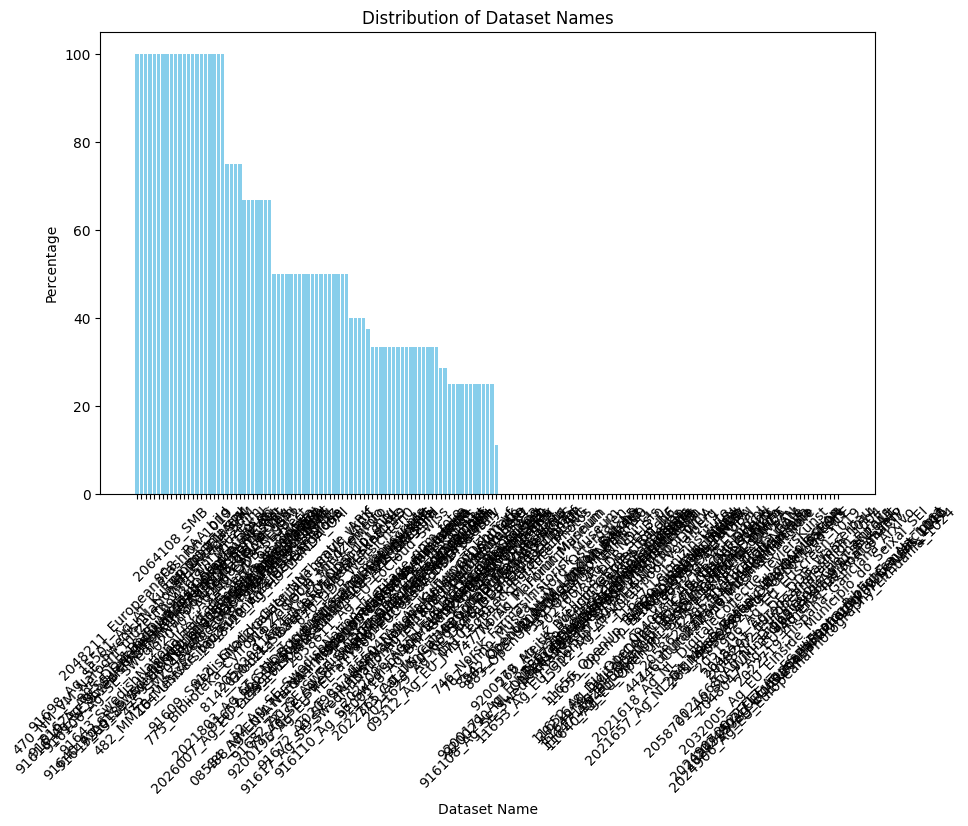

In [45]:
threshold = 0.5


df['prediction'] = df['watermark'].apply(lambda x: 'watermark' if x > threshold else 'no_watermark')

count_df = df.groupby(['dataset_name','prediction','provider','aggregator']).size().reset_index(name='counts')
count_df = count_df.rename(columns = {'counts':'n_images_processed'})
print(count_df)

response = requests.get('https://api.europeana.eu/record/v2/search.json?wskey=api2demo&query=*&rows=0&profile=facets&facet=edm_datasetName&f.edm_datasetName.facet.limit=10000')
response = response.json()
dataset_count_df = pd.DataFrame(response['facets'][0]['fields'])

per_dict = []
for dataset_name in count_df['dataset_name'].unique():
    _df = count_df.loc[count_df['dataset_name'] == dataset_name]

    provider = _df['provider'].values[0]
    aggregator = _df['aggregator'].values[0]

    n_no_watermark = _df['n_images_processed'].loc[_df['prediction'] == 'no_watermark']
    if not n_no_watermark.empty:
        n_no_watermark = n_no_watermark.sum()
    else:
        n_no_watermark = 0
        
    n_watermark = _df['n_images_processed'].loc[_df['prediction'] == 'watermark']
    if not n_watermark.empty:
        n_watermark = n_watermark.sum()
    else:
        n_watermark = 0

    n_images = n_watermark + n_no_watermark
    per_watermarks = round(100.0*n_watermark/n_images,2)

    per_dict.append({
        'dataset_name':dataset_name, 
        'provider':provider,
        'aggregator':aggregator,
        'percentage_watermarks':per_watermarks,
        'n_images_processed':n_images,
        'n_watermarks_detected':n_watermark
    })

per_df = pd.DataFrame(per_dict)   
per_df = per_df.sort_values(by='percentage_watermarks', ascending=False)  
print(per_df.shape)

def get_dataset_url(x):
    url = f"https://www.europeana.eu/en/search?query=edm_datasetName%3A{x.split('_')[0]}%2A&page=1&view=grid"
    return url

def get_number_items_dataset(x):
    return dataset_count_df['count'].loc[dataset_count_df['label'] == x].values[0]
    

per_df['url'] = per_df['dataset_name'].apply(get_dataset_url)
per_df['count_dataset'] = per_df['dataset_name'].apply(get_number_items_dataset)

columns = [
    'dataset_name',
    'provider',
    'aggregator',
    'url',
    'percentage_watermarks',
    'count_dataset',
    'n_images_processed',
    'n_watermarks_detected',
]

per_df.to_csv('/storage/results/inference_report.csv',index = False)


# Plot
plt.figure(figsize=(10, 6))
plt.bar(per_df['dataset_name'], per_df['percentage_watermarks'], color='skyblue')
plt.xlabel('Dataset Name')
plt.ylabel('Percentage')
plt.title('Distribution of Dataset Names')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.show()

In [47]:

threshold_percentage = 0.0

reduced_per_df = per_df.loc[per_df['percentage_watermarks'] >= threshold_percentage]
print(reduced_per_df.shape)

output_df = pd.DataFrame()
filtered_names = []
for dataset_name in reduced_per_df['dataset_name'].unique():
    _df = df.loc[df['dataset_name'] == dataset_name]

    _df = _df.drop(columns = ['prediction'])
    _df = _df.rename(columns = {'watermark':'confidence_score'})

    _df = _df.sort_values(by='confidence_score', ascending=False)  
    _df = _df.head(5)

    output_df = pd.concat([output_df,_df])

print(output_df.columns)
print(output_df.shape)

columns = ['europeana_id','confidence_score','dataset_name','provider','aggregator','uri','image_url','country','rights']
output_df = output_df[columns]



output_df.to_csv('/storage/results/inference_gallery.csv',index = False)





(165, 8)
Index(['confidence_score', 'europeana_id', 'uri', 'type', 'image_url',
       'country', 'description', 'title', 'creator', 'language', 'rights',
       'provider', 'dataset_name', 'concept', 'concept_lang',
       'description_lang', 'title_lang', 'aggregator'],
      dtype='object')
(491, 18)


In [11]:
output_df

,europeana_id,confidence_score,dataset_name,provider,uri,image_url,country,rights
3,/2022713/oai_rebae_mcu_es_183695,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
297,/2022713/oai_rebae_mcu_es_183868,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
457,/2022713/oai_rebae_mcu_es_183770,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
453,/2022713/oai_rebae_mcu_es_183936,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
400,/2022713/oai_rebae_mcu_es_184071,1.000000,2022713_Ag_ES_Hispana_ccbae,Collective Catalog of the Library Network of t...,http://data.europeana.eu/item/2022713/oai_reba...,http://www.mcu.es/ccbae/i18n/catalogo_imagenes...,Spain,http://creativecommons.org/publicdomain/mark/1.0/
...,...,...,...,...,...,...,...,...
2393,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999996,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/88598,Poland,http://rightsstatements.org/vocab/InC/1.0/
3571,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999988,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/88588,Poland,http://rightsstatements.org/vocab/InC/1.0/
4061,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999982,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/99883,Poland,http://rightsstatements.org/vocab/InC/1.0/
5536,/912/https___biblioteka_teatrnn_pl_dlibra_publ...,0.999956,912__GrodzkaGate_NNTheatre_JARK,Grodzka Gate – NN Theatre,http://data.europeana.eu/item/912/https___bibl...,https://biblioteka.teatrnn.pl/Content/99672,Poland,http://rightsstatements.org/vocab/InC/1.0/
